In [9]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
PATH_CSV = './top_3827348_songs.csv'
PATH_CSV_CLEAN = './clean_top_3827348_songs.csv'
SAMPLE_SIZE = None
SEED = 42
TRAIN_TEST_SPLIT = 0.75

In [11]:
def to_str(x):
    return x[2:-1]

def to_list(x):
    return [y for y in to_str(x).split(',')]

if os.path.exists(PATH_CSV):
    df_complete = pd.read_csv(PATH_CSV)
else:
    df_complete = pd.read_csv(
        PATH_CSV,
        usecols=[
            'id', 'name', 'duration', 'explicit', 'popularity', 'loudness', 'tempo',
            'time_signature', 'key', 'mode', 'acousticness', 'danceability',
            'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'
        ],
        converters={
            'id': to_str, 'name': to_str, 'duration': np.int32, 'explicit': np.int32,
            'popularity': np.int32, 'loudness': np.float32, 'tempo': np.float32,
            'time_signature': np.int32, 'key': np.int32, 'mode': np.int32, 'acousticness': np.float32,
            'danceability': np.float32, 'energy': np.float32, 'instrumentalness': np.float32,
            'liveness': np.float32, 'speechiness': np.float32, 'valence': np.float32
        }
    )
    df_complete.to_csv(PATH_CSV)

if 'Unnamed: 0' in df_complete.columns:
    df_complete = df_complete.drop(columns='Unnamed: 0')
df_complete.head()

,id,name,duration,explicit,popularity,loudness,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,artist_ids,artist_names,artist_followers,artist_popularities,album_ids,album_names,album_types,album_release_dates,album_popularities,genres
0,b'0000gBWfr2zIFzE5tDzxca',b'Sella Stercoraria',507987,0,3,-8.065,80.509003,4,9,0,0.000013,0.322,0.670,0.559000,0.3510,0.0449,0.176,b'0Tgtl5beIMahbtIzV5jBXw',b'Rattenf\xc3\xa4nger',b'950',b'7',b'1HyOZ6YUbaWNdnPjo9UOUE',b'Geisslerlieder',b'album',b'1575590400000',b'8',b'ukrainian metal'
1,b'0003Z98F6hUq7XxqSRM87H',b'\xd0\x9c\xd0\xb5\xd0\xbd\xd1\x8f \xd0\xb1\xd0\xbe\xd0\xbb\xd1\x8c\xd1\x88\xd0\xb5 \xd1\x82\xd1\x83\xd1\x82 \xd0\xbd\xd0\xb5\xd1\x82',241666,1,18,-5.408,138.076004,4,1,1,0.086000,0.733,0.711,0.000000,0.4510,0.1580,0.346,b'08RxfNkJpjJ4dJb4xASWzj',b'Jacques Anthony',b'0',b'0',b'0003Z98F6hUq7XxqSRM87H',b'#NoName',b'album',b'1436400000000',b'17',"b'russian hip hop,russian trap'"
2,b'0003q2V7hAiIYyzXV4sNyQ',"b'Das wilde Pack, Teil 1: Das wilde Pack, Kapitel 5'",200974,0,11,-14.880,79.250000,3,0,1,0.500000,0.520,0.416,0.000000,0.5950,0.9540,0.538,b'7vYT04Nb7z9QUTf4F8oG2c',b'Das wilde Pack',b'3090',b'24',b'7uwWybYhEK3rhg6QDJo9Rw',b'Teil 1: Das wilde Pack',b'album',b'1225238400000',b'21',b'kleine hoerspiel'
3,b'000490QTLqT1ftnfwj3kGF',b'Disco Guitar',73195,0,2,-14.496,157.445007,4,1,1,0.665000,0.742,0.661,0.000052,0.3070,0.1180,0.922,b'0cKrM2XKF7wxyfEQDauvyQ',b'DJ Godfather',b'0',b'0',b'1sDqcoOS1JuKSFHNkcU4jL',b'Da Bomb Vol 1',b'album',b'975974400000',b'10',"b'electro,ghettotech'"
4,b'00053lDuLvN8Q8voGT3GCt',b'Soki',279880,0,1,-5.135,104.961998,4,7,1,0.673000,0.622,0.734,0.000002,0.0954,0.0476,0.481,b'6HAIuUS4d8W4zjDTl6rsaU',b'Barbara Kanam',b'0',b'0',b'6XAXAPWJCpXmracdcF30Jr',b'Karibu',b'album',b'1230768000000',b'14',b'makossa'


In [12]:
if SAMPLE_SIZE is not None:
    df = df_complete.sample(n=SAMPLE_SIZE, random_state=SEED).copy()
else:
    df = df_complete.copy()
df = df.set_index('id')
df.head()
df = df.sort_values(by='popularity', ascending=False)

In [16]:
artist = "Taylor Swift"
df = df[df['artist_names'].str.contains(artist, na=False)].copy()
print(len(df))

478


In [27]:
df_data = df.select_dtypes(include='number').copy()
df_data = df_data.drop(columns=['popularity']).copy()
df_labels = df[['popularity']].copy()
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, train_size=TRAIN_TEST_SPLIT, random_state=SEED)

In [28]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [29]:
mm_scaler = MinMaxScaler()
y_train = mm_scaler.fit_transform(y_train)
y_test = mm_scaler.transform(y_test)

In [30]:
hgbm = HistGradientBoostingRegressor(random_state=SEED)
hgbm.fit(X_train, y_train)

/Users/cnorthrup/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(random_state=42)

In [31]:
results = hgbm.predict(X_test)
print(mean_squared_error(y_test, results))

0.02116704448398822


In [32]:
X_test_transformed = std_scaler.inverse_transform(X_test)
y_test_transformed = mm_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(y_test_transformed)
results_transformed = mm_scaler.inverse_transform(results.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_transformed, results_transformed)
print("Mean Squared Error:", mse)

[ 3. 74. 62. 69. 69. 64. 49. 58. 51. 79. 39. 16. 43.  5. 68.  8. 74. 65.
 18. 58. 34. 53. 59. 27. 86. 36. 79. 66. 48. 57. 50. 58. 17. 56. 72. 55.
 78. 16. 60. 69. 73. 23. 58.  3. 68. 41. 24. 67. 25. 53. 25. 69. 39. 57.
 56. 58. 69. 41.  3. 55. 62. 69. 71. 50. 60.  6. 69. 27. 37. 25. 42.  3.
  5. 38. 17. 78.  6. 28. 77. 23. 39. 72. 56. 37. 39. 65. 60. 19. 75. 25.
 39. 61. 73. 53. 43. 44. 56. 56. 39. 40. 76.  7. 73. 64. 50. 63. 58. 60.
 72. 18. 63. 23. 75. 78. 70. 27. 67. 74. 67. 38.]
Mean Squared Error: 145.81976945019488


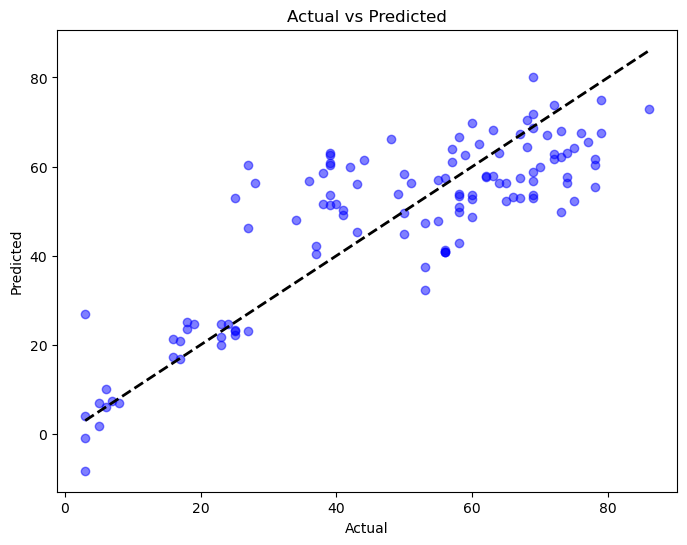

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, results_transformed, color='blue', alpha=0.5)
plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [34]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_transformed, results_transformed)
print("R-squared Score:", r2)

R-squared Score: 0.6989024863672151


In [39]:
from sklearn.metrics import median_absolute_error
med_ae = median_absolute_error(y_test_transformed, results_transformed)
print("Median absolute error:", med_ae)

Median absolute error: 8.284311677126908
